<a href="https://colab.research.google.com/github/RedBatProject/Works/blob/main/work_46_rumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install transformers

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np
from PIL import Image
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
from itertools import chain
import tensorflow as tf
# from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
# from transformers import XLNetTokenizer, TFXLNetModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, log_loss
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
%matplotlib inline

# Load Data

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"willyvonka","key":"2e9df042075e2ca80586e55c66c656a0"}'}

In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d nicolemichelle/pheme-dataset-for-rumour-detection

  0% 0.00/2.58M [00:00<?, ?B/s]
100% 2.58M/2.58M [00:00<00:00, 86.8MB/s]


In [ ]:
!unzip /content/pheme-dataset-for-rumour-detection.zip

Archive:  /content/pheme-dataset-for-rumour-detection.zip
  inflating: dataset.csv             


# Read Data

In [68]:
import os
path0 = '/content/drive/MyDrive/work 46/'
path = '/content/drive/MyDrive/work 46/results/'
#
# os.mkdir(path0)
# os.mkdir(path)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv /content/dataset.csv '/content/drive/MyDrive/work 47/data.csv'

In [4]:
df=pd.read_csv("/content/drive/MyDrive/work 46/data.csv")
df

NameError: ignored

In [ ]:
df.head()

,text,is_rumor,user.handle,topic
0,Charlie Hebdo became well known for publishing...,0.0,BBCDanielS,charliehebdo
1,"Now 10 dead in a shooting there today RT ""@BBC...",0.0,robbylevy,charliehebdo
2,@BBCDanielS @BBCWorld I'm guessing this is bei...,0.0,ModerateInAll,charliehebdo
3,@BBCDanielS @BBCWorld why would you mention th...,0.0,GabTarquini,charliehebdo
4,@BBCDanielS @BBCWorld perps identified?,0.0,freethought41,charliehebdo


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62445 entries, 0 to 62444
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text         62445 non-null  object 
 1   is_rumor     62443 non-null  float64
 2   user.handle  62443 non-null  object 
 3   topic        49668 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [ ]:
df.isnull().sum()

text               0
is_rumor           2
user.handle        2
topic          12777
dtype: int64

In [8]:
df = df[['text','is_rumor']].copy()

In [9]:
# df.drop(['Unnamed: 0'], axis=1,inplace=True)
# df.drop(['URLs','Unnamed: 0'], axis=1,inplace=True)


In [10]:
df.head()

,text,is_rumor
0,Charlie Hebdo became well known for publishing...,0.0
1,"Now 10 dead in a shooting there today RT ""@BBC...",0.0
2,@BBCDanielS @BBCWorld I'm guessing this is bei...,0.0
3,@BBCDanielS @BBCWorld why would you mention th...,0.0
4,@BBCDanielS @BBCWorld perps identified?,0.0


In [11]:
df.dropna(inplace=True)

### You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

In [12]:
# df.columns = ['head','text','target']

In [13]:
df.is_rumor.value_counts()

0.0    48619
1.0    13824
Name: is_rumor, dtype: int64

In [14]:
df['label'] = df['is_rumor']

In [15]:
df['label'].replace({1:'Rumor',0:'not Rumor'},inplace=True)

In [16]:
df.label.value_counts()


not Rumor    48619
Rumor        13824
Name: label, dtype: int64

In [17]:
df = df.sample(5800)

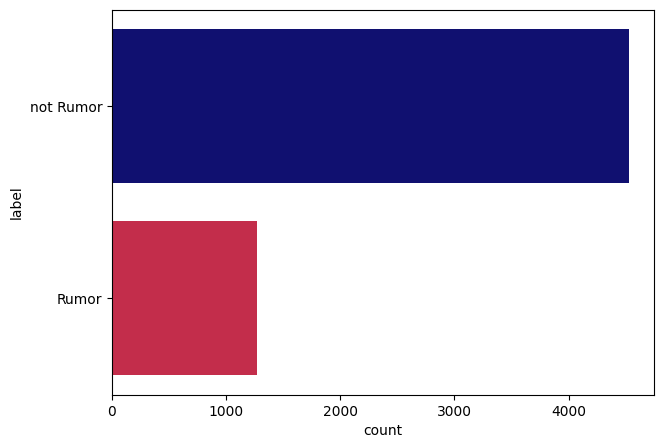

In [18]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, y="label",palette=["navy","crimson"])
# plt.title("Compare Target")
df['label'].to_csv(f'{path}_labels.csv',index=False)
plt.savefig(f'{path}_labels.png',bbox_inches='tight')
plt.show()

Pre Processing

In [19]:
import re

In [20]:
def removepunc(x):
    x = x.lower()
    x = re.sub(r" ' ","",x)
    x = re.sub(r"'","",x)
    x = re.sub(r"\r"," ",x)
    x = re.sub(r"\n"," ",x)
    # x = re.sub(r" / ","",x)

    # x = re.sub(r" . ","",x)

    x = re.sub(r"(@[A-Za-z]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x)
    # x = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", x)
    # x = re.sub(r"  "," ",x)
    # x = re.sub(r"  "," ",x)
    # x = re.sub(r"  "," ",x)
    # x = re.sub(r"  "," ",x)
    # x = re.sub(r"  "," ",x)
    # x = re.sub(r"  "," ",x)
    # x = re.sub(r"  "," ",x)
    # x = re.sub(r"  "," ",x)
    return x

In [22]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
stop_words = set(stopwords.words('english'))

In [24]:
def lenword(x):
  # l = x.spllit()
  x = ' '.join([word for word in x.split() if (len(word) > 1 or word in (['i','a']))])
  x = ' '.join([word for word in x.split() if word not in stop_words])

  return x

In [25]:
df['text'] = df['text'].apply(lambda x:removepunc(x))

In [26]:
df['text'] = df['text'].apply(lambda x:lenword(x))

In [27]:
df['text']

233                                        1903 trying say
36697    boubaker alhakim connection actual claim franc...
7430     01 1684 agree collective struggle across human...
35971    course another siege going jewish kosher groce...
24849    io ya know isis twitter propagandist mehdi sai...
                               ...                        
1129     sorry even stupid divine law tweet im sure kil...
8320                                            right dear
56331    sure afford read matter laziness disorganizati...
41291         04 awe poor wittle thing need attention dont
36001                                    spcial force gign
Name: text, Length: 5800, dtype: object

# Count Character

In [ ]:
df["character_count"]=df["text"].str.len()

# Count Word

In [ ]:
df['word_count'] = df['text'].str.split().str.len()
df["character_count"]=df["text"].str.len()

In [ ]:
df['word_count'].max()

29

# Count Sentence

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df['sentence_count'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))


In [ ]:
df

,head,text,target,label,character_count,word_count,sentence_count
0,Four ways Bob Corker skewered Donald Trump,image copyright getty images on sunday morning...,1,Real,6186,1045,1
1,Linklater's war veteran comedy speaks to moder...,london reuters last flag flying a comedydrama ...,1,Real,3176,543,1
2,Trump’s Fight With Corker Jeopardizes His Legi...,the feud broke into public view last week when...,1,Real,6335,1079,1
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,mexico city reuters egypts cheiron holdings li...,1,Real,609,96,1
4,Jason Aldean opens 'SNL' with Vegas tribute,country singer jason aldean who was performing...,1,Real,204,37,1
...,...,...,...,...,...,...,...
4004,Trends to Watch,trends to watch of readers think this story is...,0,Fake,1713,316,1
4005,Trump Jr. Is Soon To Give A 30-Minute Speech F...,trump jr is soon to give a 30minute speech for...,0,Fake,276,55,1
4006,"Ron Paul on Trump, Anarchism & the AltRight",,0,Fake,0,0,0
4007,China to accept overseas trial data in bid to ...,shanghai reuters china said it plans to accept...,1,Real,1925,315,1


In [ ]:
# cor=df[["target","character_count","word_count"]].corr()
# plt.figure(figsize=(7,5))
# sns.heatmap(cor,annot=True,cmap="jet",linewidths=7, linecolor='darkorange')
# cor.to_csv(f'{path}_cor.csv')
# plt.savefig(f'{path}_cor.png',bbox_inches='tight')
# plt.show()

# Data Length

In [ ]:
df['len'] = df['text'].str.split().apply(len)

In [ ]:
df = df[df['len']>5]

In [ ]:
# notdisaster_len=df[df["target"]==0]["text"].str.split().apply(len)
# disaster_len=df[df["target"]==1]["text"].str.split().apply(len)
# plt.figure(figsize=(7,5))
# plt.hist(notdisaster_len, bins=40,label='Fake',color="red")
# plt.hist(disaster_len , bins=40, label='Real',color="green")
# plt.xlim(0,2000)
# plt.title("Real Vs Fake tweet")
# plt.legend()
# notdisaster_len.to_csv(f'{path}_Fake_len.csv',index=False)
# disaster_len.to_csv(f'{path}_Real_len.csv',index=False)

# plt.savefig(f'{path}_Real-Fake_len.png',bbox_inches='tight')
# plt.show()

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df=pd.read_csv("/content/drive/MyDrive/work 46/data.csv")
df

,text,is_rumor,user.handle,topic
0,Charlie Hebdo became well known for publishing...,0.0,BBCDanielS,charliehebdo
1,"Now 10 dead in a shooting there today RT ""@BBC...",0.0,robbylevy,charliehebdo
2,@BBCDanielS @BBCWorld I'm guessing this is bei...,0.0,ModerateInAll,charliehebdo
3,@BBCDanielS @BBCWorld why would you mention th...,0.0,GabTarquini,charliehebdo
4,@BBCDanielS @BBCWorld perps identified?,0.0,freethought41,charliehebdo
...,...,...,...,...
62440,@AnonyOps @Xplant So that means its ok to torc...,1.0,RianAlden,ferguson
62441,"@RianAlden not at all, but they need to change...",1.0,Xplant,ferguson
62442,@Xplant @AnonyOps Absoluteky. But it pains me...,1.0,RianAlden,ferguson
62443,@Xplant @AnonyOps I'm curious how many of thes...,1.0,RianAlden,ferguson


# ALL Data Wordcloud

In [ ]:
# plt.figure(figsize=(16,8),dpi=600)
# all_text=" ".join(df['text'].values.tolist())
# wordcloud = WordCloud(width=1200, height=800,stopwords=STOPWORDS, background_color='navy', max_words=500,colormap="hsv").generate(all_text)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig(f'{path}_all_data.png',bbox_inches='tight')
# plt.show()

# Disaster Data Wordcloud

In [ ]:
# plt.figure(figsize=(16,8),dpi=600)
# disaster_wordcloud=df[df["target"]==1]
# disaster_text=" ".join(disaster_wordcloud['text'].values.tolist())
# wordcloud = WordCloud(width=1200, height=800,stopwords=STOPWORDS, background_color='navy', max_words=500,colormap="hsv").generate(disaster_text)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig(f'{path}_disaster_data.png',bbox_inches='tight')
# plt.show()

# Non Disaster Wordcloud

In [ ]:
# plt.figure(figsize=(16,8),dpi=600)
# nondisaster_wordcloud=df[df["target"]==0]
# nondisaster_text=" ".join(nondisaster_wordcloud['text'].values.tolist())
# wordcloud = WordCloud(width=1200, height=800,stopwords=STOPWORDS, background_color='navy', max_words=500,colormap="hsv").generate(nondisaster_text)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig(f'{path}_non_disaster_data.png',bbox_inches='tight')
# plt.show()

# 30 Most common Words From All Text

In [ ]:
# data_set =df["text"].str.split()
# all_words = list(chain.from_iterable(data_set))
# counter = Counter(all_words)
# common_words = counter.most_common(30)
# df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

# colors = ["darkviolet", "chocolate", "mediumslateblue", "darkgreen", "orangered", "mediumblue", "peru", "mediumspringgreen",
#     "lightcoral", "darkslategray", "olivedrab", "dodgerblue", "indianred", "limegreen", "steelblue",
#           "royalblue", "darkorchid", "darkturquoise", "darkgoldenrod", "mediumvioletred", "mediumaquamarine",

#           "cyan", "lime", "magenta", "gold", "purple", "tomato", "teal", "sandybrown", "mediumseagreen"]

# plt.figure(figsize=(12, 6))
# sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)
# plt.title('30 Most Common Words')
# plt.xlabel('Count')
# plt.ylabel('Word')
# df_common_words.to_csv(f'{path}_df_common_words.csv')
# plt.savefig(f'{path}_df_common_words.png',bbox_inches='tight')
# plt.show()


# Most Common Words From Non Disaster Text

In [28]:
df

,text,is_rumor,label
233,1903 trying say,0.0,not Rumor
36697,boubaker alhakim connection actual claim franc...,1.0,Rumor
7430,01 1684 agree collective struggle across human...,0.0,not Rumor
35971,course another siege going jewish kosher groce...,1.0,Rumor
24849,io ya know isis twitter propagandist mehdi sai...,0.0,not Rumor
...,...,...,...
1129,sorry even stupid divine law tweet im sure kil...,0.0,not Rumor
8320,right dear,0.0,not Rumor
56331,sure afford read matter laziness disorganizati...,1.0,Rumor
41291,04 awe poor wittle thing need attention dont,0.0,not Rumor


In [31]:
from collections import Counter

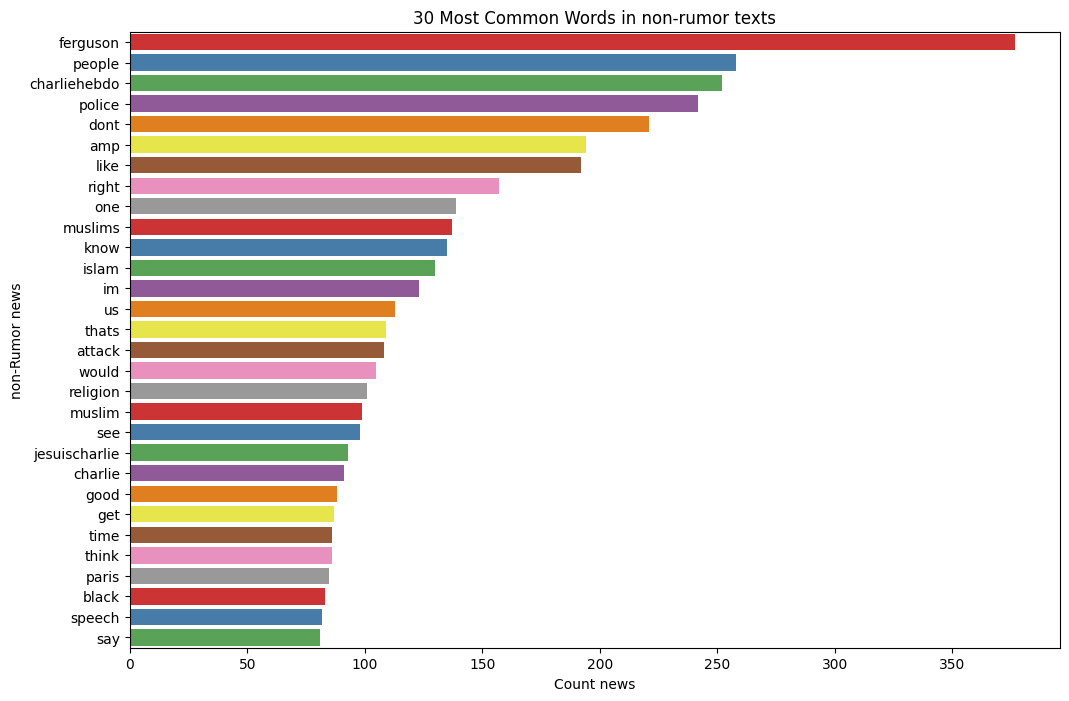

In [34]:
no_disaster_text = df[df["is_rumor"] == 0]
data_set = no_disaster_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words,palette="Set1")
plt.title('30 Most Common Words in non-rumor texts')
plt.xlabel('Count news')
plt.ylabel('non-Rumor news')
# plt.ylabel('Word')
df_common_words.to_csv(f'{path}_df_common_words_non_rumor.csv')
plt.savefig(f'{path}_df_common_words_non_rumor.png',bbox_inches='tight')
plt.show()



# 30 Most Common Words From Disaster Text

In [ ]:
# disaster_text = df[df["target"] == 1]
# data_set = disaster_text["text"].str.split()
# all_words = [word for sublist in data_set for word in sublist]
# counter = Counter(all_words)
# common_words = counter.most_common(30)
# df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
# plt.figure(figsize=(12, 8))
# colors = ["red", "green", "blue", "yellow", "orange", "purple", "pink", "brown", "gray",
#           "cyan", "magenta", "teal", "olive", "lime", "navy", "maroon", "aquamarine",
#           "coral", "gold", "indigo", "lavender", "salmon", "silver", "tan", "violet",
#           "crimson", "darkgreen", "darkblue", "darkorange", "deeppink"]
# sns.barplot(x='Count', y='Word', data=df_common_words,palette=colors)
# plt.title('30 Most Common Words Real')
# plt.xlabel('Count  Real')
# plt.ylabel('Real Word')
# df_common_words.to_csv(f'{path}_df_common_words_Real.csv')
# plt.savefig(f'{path}_df_common_words_Real.png',bbox_inches='tight')
# plt.show()


# Character Count

In [ ]:
# color=["red","green"]
# plt.figure(figsize=(7,5))

# sns.histplot(data=df,x="character_count",palette=color,kde=True,hue="label",element="step",stat="density")
# plt.title("Character Count",fontsize=15,color="darkblue")
# df['character_count'].to_csv(f'{path}_character_count.csv')
# plt.savefig(f'{path}_character_count.png',bbox_inches='tight')
# plt.show()

# Word Count

In [ ]:
# color=["navy","darkorange"]
# plt.figure(figsize=(7,5))

# sns.histplot(data=df,x="word_count",palette=color,kde=True,hue="label")
# plt.title("Word Count",fontsize=15,color="darkblue")
# plt.xlim(0,2000)
# df[['word_count','label']].to_csv(f'{path}_word_count.csv')
# plt.savefig(f'{path}_word_count.png',bbox_inches='tight')
# plt.show()

# Sentence Count

In [ ]:
df.drop(["character_count","word_count","sentence_count"],axis=1,inplace=True)

<ipython-input-106-2231b8039d64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["character_count","word_count","sentence_count"],axis=1,inplace=True)


# Average Sentence Length

In [ ]:
df['len'].mean()

482.5110330992979

In [ ]:
avg_len=df["text"].str.split().apply(len)
avg_len=avg_len.mean()
print(f"Average Text Length is : {avg_len:.2f}")

Average Text Length is : 482.51


# Maximum Length

In [ ]:
SEQ_LEN=30

In [ ]:

text_data=df["text"]
label_data=df["is_rumor"]
label_data=np.array(label_data)

# Teransformer 2

In [ ]:
# SEQ_LEN = 1250

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# pip install transformers

In [ ]:
from transformers import AutoTokenizer
from transformers import TFAutoModel

In [ ]:

# 10. GPT-Neo (Generative Pre-trained Transformer Neo):
#     - Full Name: `EleutherAI/gpt-neo-1.3B,gpt2` (or other versions with varying model sizes)

# 19. MarianMT (Multilingual Transformer-based Machine Translation):
#     - Full Name: `Helsinki-NLP/opus-mt-{src}-{tgt}` (Replace `{src}` and `{tgt}` with language codes)

In [ ]:
kk = 't5-small,google/electra-base-discriminator,albert-base-v2,xlnet-base-cased,distilbert-base-uncased,roberta-base,bert-base-uncased,google/mt5-small,allenai/longformer-base-4096,facebook/bart-large,microsoft/mpnet-base,funnel-transformer/small-base,microsoft/deberta-base,google/mobilebert-uncased,xlm-roberta-base,ctrl,EleutherAI/gpt-neo-1.3B,gpt2,GPT-4/GPT-3/main,asi/albert-act-base,asi/albert-act-small,prajjwal1/bert-tiny,TheBloke/llama-2-70b-Guanaco-QLoRA-fp16,vinai/bertweet-base,nlpproject2023/small-bert,readerbench/RoBERT-small'.split(',')
len(kk)

25

In [ ]:
# m = "stevhliu/my_awesome_model"
# m = 'TheBloke/llama-2-70b-Guanaco-QLoRA-fp16'
# m = 'GPT2'
# m = 'vinai/bertweet-base'
# m = 'GPT-4/GPT-3'
# m = 'tum-nlp/IDMGSP-Galactica-TRAIN_GPT3'
# m = 'asi/albert-act-small'
# m ='prajjwal1/bert-tiny'
# m = 'asi/albert-act-base'
# m = 'albert-base-v2'

In [ ]:
# 0,
# 7
# 18
# 19
# 20


In [ ]:
'XLNetTokenizer, AlbertTokenizer, CamembertTokenizer, MBartTokenizer, PegasusTokenizer, T5Tokenizer, ReformerTokenizer, XLMRobertaTokenizer '

In [ ]:
pip install transformers[sentencepiece]


In [ ]:
import transformers

In [ ]:
pip install sentencepiece

In [ ]:
i = 23
print(kk[i])
# tokenizer = AutoTokenizer.from_pretrained(kk[i])

tokenizer = AutoTokenizer.from_pretrained('readerbench/RoBERT-small')


vinai/bertweet-base


In [ ]:
# bert = TFAutoModel.from_pretrained(kk[i],from_pt=True)
bert = TFAutoModel.from_pretrained('readerbench/RoBERT-small')


Some layers from the model checkpoint at readerbench/RoBERT-small were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at readerbench/RoBERT-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# import tensorflow as tf
# from transformers import MT5Tokenizer, TFAutoModelForSequenceClassification

# # Load pre-trained MT5 model and tokenizer
# model_name = 'google/mt5-small'
# tokenizer = MT5Tokenizer.from_pretrained(model_name)
# bert = TFAutoModel.from_pretrained(kk[i])

In [ ]:
# AutoTokenizer.from_pretrained

In [ ]:
data = df


In [ ]:
# SEQ_LEN = 22

In [ ]:
# data = data.sample(frac=0.1)

In [ ]:
Xids = np.zeros((len(data),SEQ_LEN))
Xmask = np.zeros((len(data),SEQ_LEN))


In [ ]:
Xids.shape

(5800, 30)

In [ ]:
# tokenizer.eos_token

In [ ]:
tokenizer.pad_token = '<|PAD|>'

In [ ]:
for i, sequence in enumerate(data['text']):
    tokens = tokenizer.encode_plus(
    sequence,
    max_length = SEQ_LEN,
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors='tf'
    )
    Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

In [ ]:
import tensorflow as tf

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
labels = data['is_rumor']

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [ ]:
# labels.sum(axis=0)

In [ ]:
def map_func(input_ids, masks, labels):
    return{'input_ids': input_ids, 'attention_mask':masks}, labels

In [ ]:
dataset = dataset.map(map_func)

In [ ]:
dataset = dataset.shuffle(1000000).batch(32)

In [ ]:
DS_LEN = len(list(dataset))

In [ ]:
DS_LEN

182

In [ ]:
# round(DS_LEN*SPLIT)

In [ ]:
# len(train)

In [ ]:
DATASET_SIZE = len(dataset)

In [ ]:
train_size = int(0.60 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.25 * DATASET_SIZE)

full_dataset = dataset
full_dataset = full_dataset.shuffle(123424242)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [ ]:
train = train_dataset
test = test_dataset
val = val_dataset

In [ ]:
# SPLIT = 0.8
# train = dataset.take(round(DS_LEN*SPLIT))
# val = dataset.skip(round(DS_LEN*SPLIT))
# test = dataset.skip(round())
# # del dataset

In [ ]:
labels.shape

(5800,)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPooling1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
# X = tf.keras.layers.Dense(32, activation = 'relu')(X)
# X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
y = tf.keras.layers.Dense(1, activation = 'sigmoid' , name = 'outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs = y)

In [ ]:
model.layers[2].trainable = False

In [ ]:
# model.load_weights(f'/content/drive/MyDrive/work 39 toxisity/checkpoint')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  19348736    ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

In [ ]:
import pandas as pd
from keras import layers
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, AveragePooling2D, MaxPooling2D, MaxPool1D, ZeroPadding1D, GlobalMaxPooling2D, GlobalAveragePooling2D, LSTM, SpatialDropout1D
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.utils import plot_model
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau , EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adamax
import tensorflow as tf

In [ ]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=7)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.7,
                                            min_lr=0.000001)

In [ ]:
from tensorflow.keras.optimizers import Adam, Adamax,RMSprop
# Adamax(learning_rate=0.1)

In [ ]:
# model.compile(optimizer=Adamax(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(num_thresholds=3)])
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adamax(), loss='binary_crossentropy', metrics=['accuracy'])

# tf.keras.utils.plot_model(ann_model, to_file='ann_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy','AUC'])


In [ ]:
num_epochs = 1
# early_stop = EarlyStopping(monitor='val_accuracy', patience=6,restore_best_weights=True)
history = model.fit(train,
                    # batch_size=32,
                    epochs=num_epochs,
                    # validati0on_split=0.2,
                    validation_data=[val],
                    callbacks =[
                        learning_rate_reduction,
                                es
                                ],
                    # verbose=0
                    )

109/109 [==============================] - 28s 115ms/step - loss: 0.6137 - accuracy: 0.6963 - val_loss: 0.5285 - val_accuracy: 0.7980 - lr: 0.0010


In [ ]:
# os.mkdir(f'{path0}44/')
# path0
# path2 = f'{path0}44/'

In [ ]:
model.save_weights(f'{path0}checkpoint')

In [ ]:
# precision = tf.keras.metrics.Precision()
# recall = tf.keras.metrics.Recall()
# accuracy = tf.keras.metrics.CategoricalAccuracy()
# auc = tf.keras.metrics.AUC(num_thresholds=6)
tr = []
pr = []
l = 0
# for k in range(len(val)):


for i,j in test.take(-1):
  # l += 1
  # print(l)
  s = model.predict(i,verbose=0)
  tr.append(np.array(j))
  pr.append(np.array(s))
#   precision.update_state(s,j)
#   accuracy.update_state(s,j)
#   auc.update_state(s,j)
#   recall.update_state(s,j)
# pre = precision.result().numpy()
# rec = recall.result().numpy()
# au = auc.result().numpy()
# acc = accuracy.result().numpy()
# print(pre,rec,au,acc)

In [ ]:
yp = np.concatenate([y for y in pr], axis=0)
yt = np.concatenate([y for y in tr], axis=0)


In [ ]:
yp[yp < 0.5] = 0
yp[yp > 0.5] = 1
# y1 = y_test
print(classification_report(yt,yp,zero_division=True))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1124
         1.0       0.91      0.85      0.88       316

    accuracy                           0.95      1440
   macro avg       0.94      0.91      0.92      1440
weighted avg       0.95      0.95      0.95      1440



In [ ]:
yp = yp.reshape(-1,)

In [ ]:
np.sum(yt==yp)/yt.shape[0]

0.9493055555555555

In [ ]:
yp = np.concatenate([y for y in pr], axis=0)
yt = np.concatenate([y for y in tr], axis=0)


In [ ]:
yp

array([[0.01214484],
       [0.81260866],
       [0.9497412 ],
       ...,
       [0.30021286],
       [0.00626949],
       [0.93072444]], dtype=float32)

In [ ]:
y1 = yp.reshape(-1,) # np.zeros((y_test.shape[0],))
y2 = yt.reshape(-1,)
ff = pd.DataFrame(columns=['real','predicted'],)
ff['real'] = y2
ff['predicted'] = y1
pa = 'GPT'

ff.to_csv(f'{path0}{pa}3.csv',index=False)

In [ ]:
from sklearn.metrics import classification_report

def savemod(model,pa,y_test,X_test,path=path):
    y2 = model.predict(X_test)
    y2_ = np.array(y2)
    y2_[y2_ < 0.5] = 0
    y2_[y2_ > 0.5] = 1
    y1 = y_test
    print(classification_report(y1,y2_,target_names=target_names))
    y1 = y1.reshape(-1,) # np.zeros((y_test.shape[0],))
    y2 = y2.reshape(-1,)
    # y2 = y_   # np.zeros((y_test.shape[0],))
    # y2[y2 < 0.5] = 0
    # y2[y2 > 0.5] = 1

    # for i in range(len(y_test)):
        # y1[i] = 1 if y1> 0.5 else 0
        # y2[i] = y_test[i].argmax()
    ff = pd.DataFrame(columns=['real','predicted'],)
    ff['real'] = y2
    ff['predicted'] = y1


    ff.to_csv(f'{path}{pa}.csv',index=False)

In [ ]:
# model.compile(optimizer=Adamax(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(num_thresholds=3)])
model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy','AUC'])

# tf.keras.utils.plot_model(ann_model, to_file='ann_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
num_epochs = 50
# early_stop = EarlyStopping(monitor='val_accuracy', patience=6,restore_best_weights=True)
history = model.fit(train,
                    # batch_size=32,
                    epochs=num_epochs,
                    # validati0on_split=0.2,
                    validation_data=[val],
                    callbacks =[
                        learning_rate_reduction,
                                es
                                ],
                    # verbose=0
                    )

# simple models

In [37]:
data = df

In [38]:
import tensorflow as tf
import pandas as pd
from keras import layers
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, AveragePooling2D, MaxPooling2D, MaxPool1D, ZeroPadding1D, GlobalMaxPooling2D, GlobalAveragePooling2D, LSTM, SpatialDropout1D
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.utils import plot_model
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau , EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adamax
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Adamax,RMSprop
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.7,
                                            min_lr=0.000001)

In [39]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 30
max_words = 3000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['text'])
Xsequences = tokenizer.texts_to_sequences(data['text'])

In [40]:
Xsequences = tf.keras.preprocessing.sequence.pad_sequences(Xsequences, maxlen=maxlen)

In [46]:
data

,text,is_rumor,label
233,1903 trying say,0.0,not Rumor
36697,boubaker alhakim connection actual claim franc...,1.0,Rumor
7430,01 1684 agree collective struggle across human...,0.0,not Rumor
35971,course another siege going jewish kosher groce...,1.0,Rumor
24849,io ya know isis twitter propagandist mehdi sai...,0.0,not Rumor
...,...,...,...
1129,sorry even stupid divine law tweet im sure kil...,0.0,not Rumor
8320,right dear,0.0,not Rumor
56331,sure afford read matter laziness disorganizati...,1.0,Rumor
41291,04 awe poor wittle thing need attention dont,0.0,not Rumor


In [48]:
labels = data['is_rumor']

In [49]:
dataset = tf.data.Dataset.from_tensor_slices((Xsequences, labels))

In [50]:
dataset = dataset.shuffle(1000000).batch(32)

In [51]:
DS_LEN = len(list(dataset))

In [52]:
DS_LEN

182

In [53]:
DATASET_SIZE = len(dataset)

In [54]:
train_size = int(0.60 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.25 * DATASET_SIZE)

full_dataset = dataset
full_dataset = full_dataset.shuffle(123424242)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [55]:
train = train_dataset
test = test_dataset
val = val_dataset

In [56]:
embedding_dim = 30

In [66]:
pa = '2D-CNN'

In [58]:
# Define model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words,
                              output_dim=embedding_dim,input_length=maxlen,
                              # weights=[embedding_matrix],
                              # trainable=True
                              ),
    tf.keras.layers.Conv1D(32, 2, activation='relu',),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    # tf.keras.layers.Conv1D(128, 2, activation='relu'),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),

    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 30)            90000     
                                                                 
 conv1d (Conv1D)             (None, 29, 32)            1952      
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 64)            4160      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [59]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=7)

In [60]:
# Train model
num_epochs = 6
history = model.fit(train,
                    # batch_size=32,
                    epochs=num_epochs,
                    # validati0on_split=0.2,
                    validation_data=[val],
                    callbacks =[
                        learning_rate_reduction,
                                es
                                ],
                    )

Epoch 1/6
109/109 [==============================] - 6s 36ms/step - loss: 0.5490 - accuracy: 0.7777 - val_loss: 0.5402 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 2/6
109/109 [==============================] - 5s 43ms/step - loss: 0.5204 - accuracy: 0.7758 - val_loss: 0.5323 - val_accuracy: 0.7522 - lr: 0.0010
Epoch 3/6
109/109 [==============================] - 3s 25ms/step - loss: 0.4385 - accuracy: 0.8039 - val_loss: 0.3902 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 4/6
109/109 [==============================] - 2s 22ms/step - loss: 0.3626 - accuracy: 0.8533 - val_loss: 0.2869 - val_accuracy: 0.8895 - lr: 0.0010
Epoch 5/6
109/109 [==============================] - 2s 22ms/step - loss: 0.3313 - accuracy: 0.8658 - val_loss: 0.2818 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 6/6
109/109 [==============================] - 3s 26ms/step - loss: 0.2884 - accuracy: 0.8876 - val_loss: 0.2511 - val_accuracy: 0.9094 - lr: 0.0010


In [61]:
tr = []
pr = []
l = 0
for i,j in test.take(-1):
  s = model.predict(i,verbose=0)
  tr.append(np.array(j))
  pr.append(np.array(s))

In [62]:
yp = np.concatenate([y for y in pr], axis=0)
yt = np.concatenate([y for y in tr], axis=0)


In [63]:
from sklearn.metrics import classification_report


In [64]:
yp[yp < 0.5] = 0
yp[yp > 0.5] = 1
# y1 = y_test
print(classification_report(yt,yp,zero_division=True))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      1143
         1.0       0.88      0.63      0.74       297

    accuracy                           0.91      1440
   macro avg       0.89      0.81      0.84      1440
weighted avg       0.90      0.91      0.90      1440



In [65]:
yp = np.concatenate([y for y in pr], axis=0)
yt = np.concatenate([y for y in tr], axis=0)


In [69]:
y1 = yp.reshape(-1,) # np.zeros((y_test.shape[0],))
y2 = yt.reshape(-1,)
ff = pd.DataFrame(columns=['real','predicted'],)
ff['real'] = y2
ff['predicted'] = y1
# pa = 'Albert'

ff.to_csv(f'{path}{pa}.csv',index=False)

# visualization

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix



In [36]:
path = '/content/drive/MyDrive/work 46/results/'

In [106]:
name = 'ALBERT'
dg = pd.read_csv(f'/content/drive/MyDrive/work 46/Albert23.csv')
yp,yt = dg['predicted'].to_numpy(),dg['real'].to_numpy()
yp,yt

(array([0.13352054, 0.20754613, 0.02316395, ..., 0.1919491 , 0.09230134,
        0.19089311]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [92]:
# name = 'Bert-base-uncased'

In [93]:
yp[yp < 0.5] = 0
yp[yp > 0.5] = 1

In [94]:
y_test, y_pred = yt,yp

In [95]:
# k = pd.DataFrame()
k[f'{name}'] = [accuracy_score(y_test, y_pred),precision_score(y_test, y_pred),recall_score(y_test, y_pred),f1_score(y_test, y_pred),roc_auc_score(y_test, y_pred)]
k

,CNN,LSTM,GPT2,ALBERT
0,0.906250,0.890278,0.949306,0.924306
1,0.878505,0.804781,0.911864,0.854331
2,0.632997,0.649518,0.851266,0.750865
3,0.735812,0.718861,0.880524,0.799263
4,0.805125,0.803058,0.914067,0.859360


In [100]:
k.to_csv(f'{path}performance.csv')

In [97]:
k.index = ['accuracy','precision','recall','f1','roc-auc']

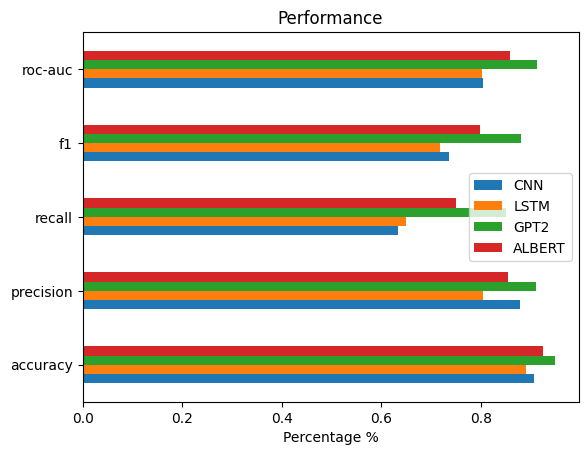

In [147]:
k.plot(kind='barh')
name = 'Performance'
# plt.xlim(0.8,1.05)
plt.xlabel('Percentage %')
plt.title('Performance')
plt.savefig(f'{path}{name}.png',bbox_inches='tight')

<ipython-input-148-d480f8d48065>:1: UserWarning: 
The markers list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=k,markers='p',markersize=10)


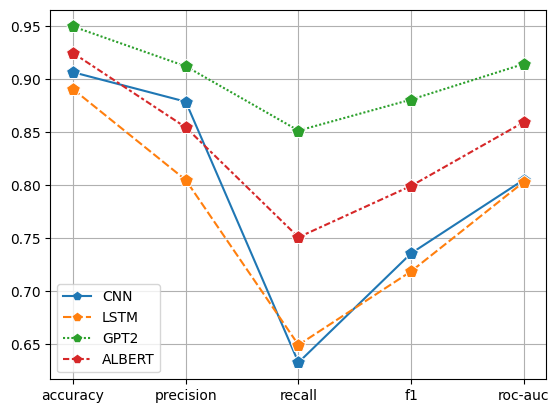

In [148]:
sns.lineplot(data=k,markers='p',markersize=10)
plt.grid()
plt.savefig(f'{path}{name}_line.png',bbox_inches='tight')

# Model predict

In [ ]:
pred = model.predict([X_test, test_mask])
final_pred = np.where(pred >= 0.5, 1, 0)


# ROC Curve

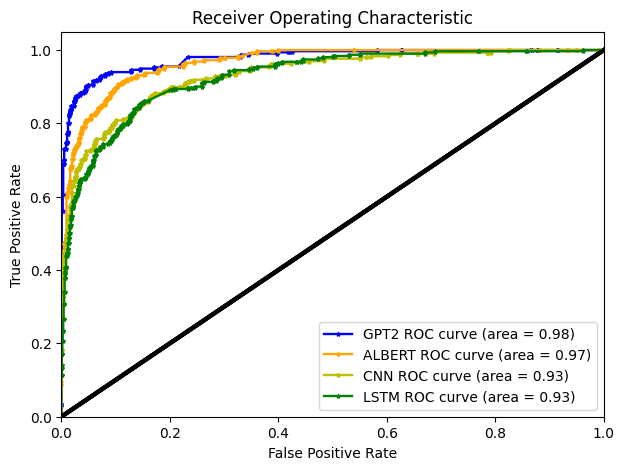

In [133]:
names = ['GPT3','Albert23','2D-CNN','2D-LSTM']
name_ = ['GPT2','ALBERT','CNN','LSTM']
clr = ['b','orange','y','g']
plt.figure(figsize=(7,5))

for i,j,c in zip(names,name_,clr):
    # name = 'ALBERT'
    dg = pd.read_csv(f'/content/drive/MyDrive/work 46/{i}.csv')
    yp,yt = dg['predicted'].to_numpy(),dg['real'].to_numpy()
    # yp,yt
    fpr, tpr, thresholds = roc_curve(yt,yp)
    roc_auc = auc(fpr, tpr)
    # red='b'
    plt.plot(fpr, tpr, label=f'{j} ROC curve (area = %0.2f)' % roc_auc,color=f"{c}",lw=1.7,marker="*",markersize=3)
    plt.plot([0, 1], [0, 1],color="black",lw=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    ss = pd.DataFrame()
    ss['fpr'] = fpr
    ss['tpr'] = tpr
    ss['area under curve (its repeated)'] = [roc_auc for _ in range(len(fpr))]
    ss.to_csv(f'/content/drive/MyDrive/work 46/results/{j}_fpr_tpr_roc_curve.csv')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(f'/content/drive/MyDrive/work 46/results/roc_auc.png',bbox_inches='tight')
plt.show()

# Precision-Recall Curve

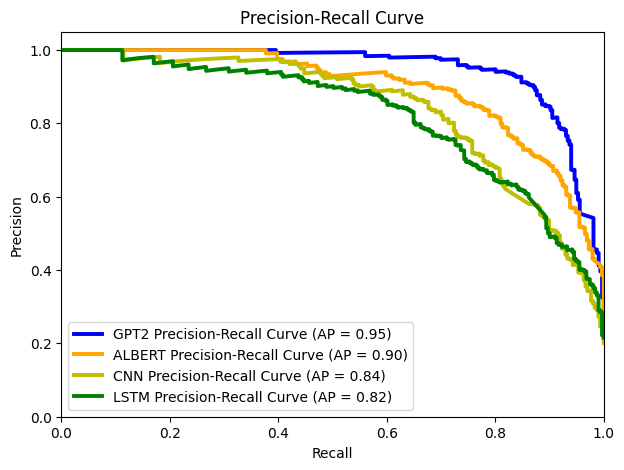

In [131]:
names = ['GPT3','Albert23','2D-CNN','2D-LSTM']
name_ = ['GPT2','ALBERT','CNN','LSTM']
# clr = ["r",'b','y','g']
plt.figure(figsize=(7,5))

for i,j,c in zip(names,name_,clr):
    # name = 'ALBERT'
    dg = pd.read_csv(f'/content/drive/MyDrive/work 46/{i}.csv')
    yp,yt = dg['predicted'].to_numpy(),dg['real'].to_numpy()
    # yp,yt
    precision, recall, thresholds = precision_recall_curve(yt,yp)
    ap_score = average_precision_score(yt,yp)
    # red='b'
    # plt.plot(fpr, tpr, label=f'{j} ROC curve (area = %0.2f)' % roc_auc,color=f"{c}",lw=1.7,marker="*",markersize=3)
    plt.plot(recall, precision, label=f'{j} Precision-Recall Curve (AP = %0.2f)' % ap_score,color=f"{c}",lw=2.8)

    # plt.plot([0, 1], [0, 1],color="black",lw=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    ss = pd.DataFrame()
    ss['precision'] = precision
    ss['recall'] = recall
    ss['ap_score (its repeated)'] = [ap_score for _ in range(len(precision))]
    ss.to_csv(f'/content/drive/MyDrive/work 46/results/{j}_Precision-Recall Curve.csv')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig(f'/content/drive/MyDrive/work 46/results/Precision_Recall_Curve.png',bbox_inches='tight')
plt.show()

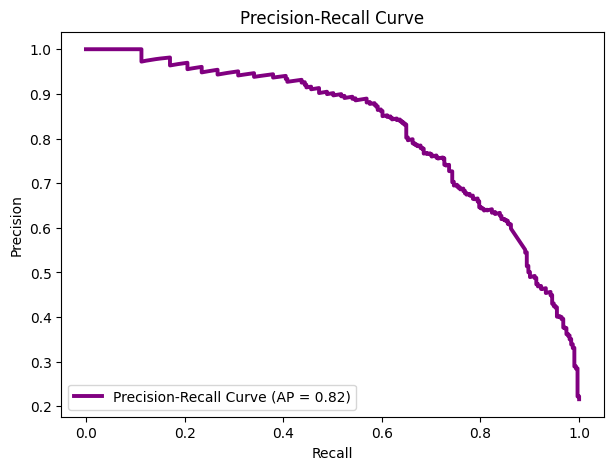

In [120]:
precision, recall, thresholds = precision_recall_curve(yt,yp)
ap_score = average_precision_score(yt,yp)
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label='Precision-Recall Curve (AP = %0.2f)' % ap_score,color="purple",lw=2.8)

plt.show()

In [ ]:
roc_auc = roc_auc_score(Y_test, pred)
plt.plot([])
plt.text(0,0, f'ROC AUC  Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center',color="indigo")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

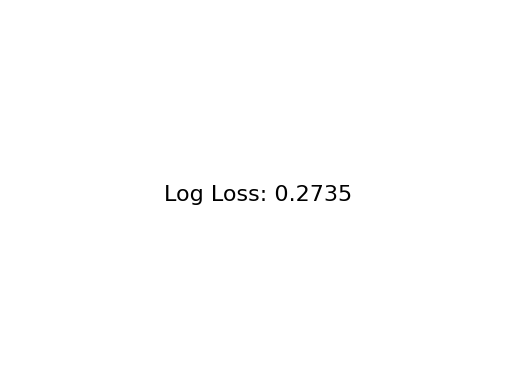

In [124]:
logarithm_loss=log_loss(yt,yp)
plt.plot([])
plt.text(0,0, f'Log Loss: {logarithm_loss:.4f}', fontsize=16, ha='center', va='center',color="black")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

In [125]:
kappa = cohen_kappa_score(yt,yp)
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="orangered")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

ValueError: ignored

In [ ]:
mcc = matthews_corrcoef(Y_test, final_pred)

# Create a plot and display the MCC value as text
plt.plot([])
plt.text(0,0, f'Matthews Correlation Coefficient: {mcc:.4f}', fontsize=16, ha='center', va='center',color="saddlebrown")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()


# Confusion Matrix

In [ ]:
label_name = ["Non Disaster", "Disaster"]
plt.figure(figsize=(7, 5))
cm = confusion_matrix(Y_test, final_pred)
sns.heatmap(cm, annot=True, cmap="rainbow",fmt="d",lw=6,linecolor="black",xticklabels=label_name, yticklabels=label_name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# Classification Report

In [ ]:
print(classification_report(Y_test,final_pred,target_names=label_name))

# Test Data Analysis


In [ ]:
df_test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [ ]:
df_test.head()

In [ ]:
df_test.info()

In [ ]:
df_test.describe()

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test.drop(["keyword","location"],axis=1,inplace=True)

In [ ]:
df_test.head()

In [ ]:
test_text=df_test["text"]

In [ ]:
def xlnet_encode(final_text_data, max_len):
    input_ids = []
    attention_masks = []

    for i in range(len(final_text_data)):
        encode_data = xlnet_tokenizer.encode_plus(final_text_data[i], add_special_tokens=True, max_length=max_len, pad_to_max_length=True, return_attention_mask=True)
        input_ids.append(encode_data['input_ids'])
        attention_masks.append(encode_data["attention_mask"])

    return np.array(input_ids), np.array(attention_masks)

In [ ]:
text_input_ids,text_attention_masks = xlnet_encode(test_text,max_len)

In [ ]:
text_input_ids = np.array(text_input_ids)
text_attention_masks = np.array(text_attention_masks)
my_pred = model.predict([text_input_ids, text_attention_masks])
predicted_labels = np.where(my_pred >= 0.5, 1, 0)
df_test['target'] = predicted_labels


In [ ]:
df_test.head(10)

In [ ]:
df_test["target"].value_counts()

In [ ]:
df0=df_test.copy()
df0.drop("text",axis=1,inplace=True)
df0.to_csv("my_submission.csv",index=False)

# Encode Data

In [ ]:
def xlnet_encode(final_text_data, max_len):
    input_ids = []
    attention_masks = []

    for i in range(len(final_text_data)):
        encode_data = xlnet_tokenizer.encode_plus(final_text_data[i], add_special_tokens=True, max_length=max_len, pad_to_max_length=True, return_attention_mask=True)
        input_ids.append(encode_data['input_ids'])
        attention_masks.append(encode_data["attention_mask"])

    return np.array(input_ids), np.array(attention_masks)


In [ ]:
text_input_ids,text_attention_masks = xlnet_encode(text_data,max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print('Text Input Ids Shape {} \nText Input Attention Mask Shape {} \nLabel Data shape {}'.format(text_input_ids.shape,text_attention_masks.shape,label_data.shape))

Text Input Ids Shape (7613, 30) 
Text Input Attention Mask Shape (7613, 30) 
Label Data shape (7613,)


In [ ]:
X_train,X_test,Y_train,Y_test,train_mask,test_mask=train_test_split(text_input_ids,label_data,text_attention_masks,test_size=0.2,random_state=42,shuffle=True)

In [ ]:
print('Train input shape {}\nTest input shape {}\nTrain label shape {}\nTest label shape {}\nTrain attention mask shape {}\nTest attention mask shape {}'.format(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape,train_mask.shape,test_mask.shape))

Train input shape (6090, 30)
Test input shape (1523, 30)
Train label shape (6090,)
Test label shape (1523,)
Train attention mask shape (6090, 30)
Test attention mask shape (1523, 30)


# XLNET Tokenizer,Model

In [ ]:
from transformers import AutoTokenizer

In [ ]:
xlnet_tokenizer = AutoTokenizer.from_pretrained('xlnet-base-cased')

In [ ]:
from transformers import TFAutoModel

In [ ]:
xlnet_model = TFAutoModel.from_pretrained('xlnet-base-cased')

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel w

# Create XLNET Model

In [ ]:
def Create_XLNet_Model():
    input_ids = tf.keras.Input(shape=(max_len,), dtype="int32")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype="int32")

    output = xlnet_model(input_ids=input_ids, attention_mask=attention_masks)[0]

    output = tf.keras.layers.GlobalMaxPooling1D()(output)

    # dense_1 = tf.keras.layers.Dense(256, activation="tanh")(output)
    # dense_2 = tf.keras.layers.Dense(128, activation="tanh")(dense_1)

    # dense_3 = tf.keras.layers.Dense(64, activation="tanh")(dense_2)
    dense_3 = tf.keras.layers.Dense(64, activation="relu")(output)


    dropout = tf.keras.layers.Dropout(0.2)(dense_3)
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
    return model





In [ ]:
tf.keras.backend.clear_session()
model = Create_XLNet_Model()

learning_rate = 1e-5
beta_1=0.9
beta_2=0.98
epsilon=1e-9
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                    #  beta_1=beta_1,
                                    #  beta_2=beta_2,
                                    #  epsilon=epsilon
                                     )

loss = "binary_crossentropy"
metric = "accuracy"
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 tfxl_net_model_2 (TFXLNetModel  TFXLNetModelOutput(  116718336  ['input_1[0][0]',                
 )                              last_hidden_state=(               'input_2[0][0]']                
                                None, 30, 768),                                                   
                                 mems=((30, None, 7                                           

In [ ]:
# plot_model(model, to_file='model_architecture.png', show_shapes=True)
# plt.figure(figsize=(25, 15))
# img = plt.imread('model_architecture.png')
# plt.imshow(img)
# plt.axis('off')
# plt.show()


In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [ ]:
# history = model.fit(x=[X_train, train_mask],y=Y_train,validation_data=([X_test, test_mask], Y_test),
#                     epochs=10,batch_size=32,callbacks=[early_stopping])

191/191 [==============================] - 121s 364ms/step - loss: 0.6405 - accuracy: 0.7140 - val_loss: 0.4813 - val_accuracy: 0.7892


In [ ]:
num_epochs = 4
# early_stop = EarlyStopping(monitor='val_accuracy', patience=6,restore_best_weights=True)
history = model.fit(train,
                    # batch_size=32,
                    epochs=num_epochs,
                    # validati0on_split=0.2,
                    validation_data=[val],
                    # callbacks =[
                        # learning_rate_reduction,
                                # es
                                # ],
                    # verbose=0
                    )

Epoch 1/4


ValueError: ignored

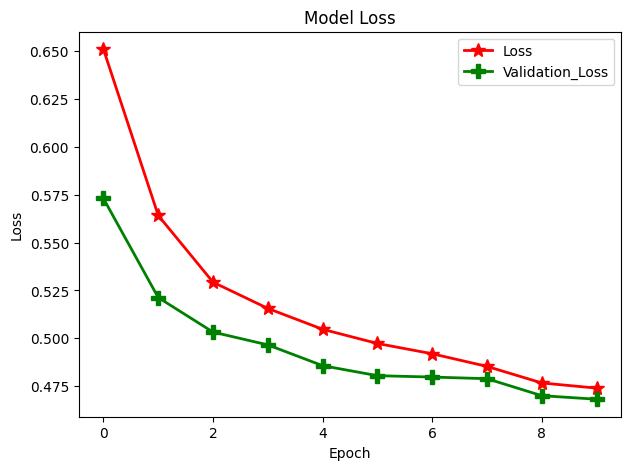

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'],lw=2,marker="*",markersize=10,color="red",label="Loss")
plt.plot(history.history['val_loss'],lw=2,marker="P",markersize=10,color="green",label="Validation_Loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()

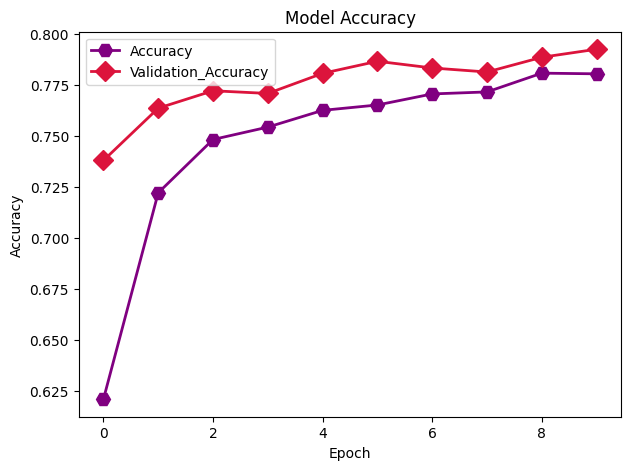

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'],lw=2,marker="H",markersize=10,color="purple",label="Accuracy")
plt.plot(history.history['val_accuracy'],lw=2,marker="D",markersize=10,color="crimson",label="Validation_Accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()

# visual